In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
train=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv",header=0)
items=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv",header=0)
item_categories=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv",header=0)
shops=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv",header=0)
test=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv",header=0).set_index('ID')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


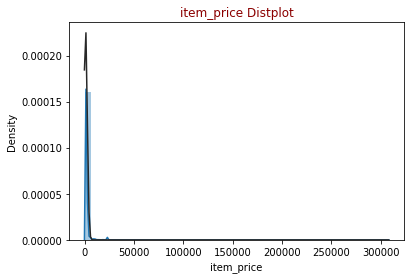

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.distplot(train["item_price"], fit=norm)
plt.title("item_price Distplot", color = "darkred")
plt.show()

seems item prices are skewed. few items have very high price.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


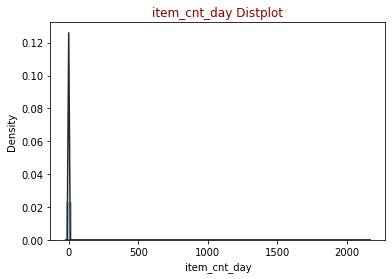

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.distplot(train["item_cnt_day"], fit=norm)
plt.title("item_cnt_day Distplot", color = "darkred")
plt.show()

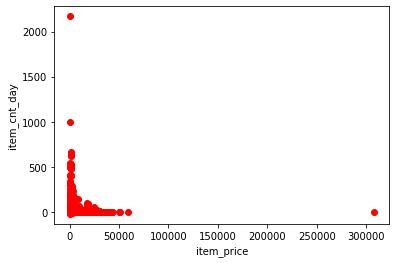

In [5]:
import matplotlib.pyplot as plt
plt.scatter(train["item_price"], train["item_cnt_day"], color = 'red')
plt.xlabel('item_price')
plt.ylabel('item_cnt_day')
plt.show()

we can see outliers

In [6]:
print(train[train["item_price"]>100000].count)

<bound method DataFrame.count of                date  date_block_num  shop_id  item_id  item_price  \
1163158  13.12.2013              11       12     6066    307980.0   

         item_cnt_day  
1163158           1.0  >


single record. so we can remove them

In [7]:
print(train[train["item_cnt_day"]>900].count)

<bound method DataFrame.count of                date  date_block_num  shop_id  item_id  item_price  \
2326930  15.01.2015              24       12    20949    4.000000   
2909818  28.10.2015              33       12    11373    0.908714   

         item_cnt_day  
2326930        1000.0  
2909818        2169.0  >


only one record above 1000. so we can remove them

In [8]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [9]:
max_date_block_num=max(train["date_block_num"])
print(max_date_block_num)
print(train[train["item_price"]<0].count)

33
<bound method DataFrame.count of               date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0>


price is negative for 1 item so removing it.

In [10]:
train=train[(train["item_price"]>0) & (train["item_price"]<100000) & (train["item_cnt_day"]<=1000)]

In [11]:
count = train.groupby(['shop_id','item_id'], as_index = False).item_price.nunique()
count[count.item_price >1]

,shop_id,item_id,item_price
10,0,51,2
21,0,111,2
33,0,306,2
113,0,1102,2
120,0,1124,2
...,...,...,...
424103,59,22114,2
424106,59,22126,2
424110,59,22139,2
424120,59,22162,2


In [12]:
train[(train.shop_id==59) & (train.item_id==22164)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2471552,11.02.2015,25,59,22164,749.0,1.0
2483751,13.02.2015,25,59,22164,749.0,1.0
2553728,29.03.2015,26,59,22164,749.0,1.0
2593334,30.04.2015,27,59,22164,699.0,1.0
2593342,22.04.2015,27,59,22164,699.0,1.0
2724674,21.07.2015,30,59,22164,699.0,1.0


different prices for same product in same shop with diff month. may be some sale or seasonal offerings. Good to add month as column

In [13]:
import re 
train['month'] = train.date.map(lambda x : re.search('\.(.*?)\.', x).group(1)).astype(np.int64)

#dataset['month']

In [14]:
test['date_block_num']=max_date_block_num+1
cols = ['date_block_num','shop_id','item_id']
dataset=pd.concat([train, test], ignore_index=True, sort=False, keys=cols)
dataset.fillna(0, inplace=True)
dataset['item_sale_revenue'] = dataset['item_price']*dataset['item_cnt_day']
shop_monthly_sale = dataset.groupby(['shop_id','date_block_num'], as_index = False).agg(shop_monthly_sale=('item_cnt_day','sum'), shop_monthly_revenue=('item_sale_revenue','sum')).sort_values(by=['shop_id','date_block_num'], ascending=True)
shop_monthly_sale["shop_monthly_sale_prev1"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_sale'].shift(1)
shop_monthly_sale["shop_monthly_sale_prev2"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_sale_prev1'].shift(1)
shop_monthly_sale["shop_monthly_sale_prev3"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_sale_prev2'].shift(1)
shop_monthly_sale["shop_monthly_sale_prev4"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_sale_prev3'].shift(1)
shop_monthly_sale["shop_monthly_sale_prev5"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_sale_prev4'].shift(1)
shop_monthly_sale["shop_monthly_sale_prev6"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_sale_prev5'].shift(1)
shop_monthly_sale["shop_monthly_revenue_prev1"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_revenue'].shift(1)
shop_monthly_sale["shop_monthly_revenue_prev2"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_revenue_prev1'].shift(1)
shop_monthly_sale["shop_monthly_revenue_prev3"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_revenue_prev2'].shift(1)
shop_monthly_sale["shop_monthly_revenue_prev4"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_revenue_prev3'].shift(1)
shop_monthly_sale["shop_monthly_revenue_prev5"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_revenue_prev4'].shift(1)
shop_monthly_sale["shop_monthly_revenue_prev6"]=shop_monthly_sale.groupby(['shop_id'])['shop_monthly_revenue_prev5'].shift(1)
shop_monthly_sale=shop_monthly_sale.fillna(0)

shop_monthly_item_sale = dataset.groupby(['shop_id','item_id','date_block_num'], as_index = False).agg(shop_monthly_item_sale=('item_cnt_day','sum'), shop_monthly_item_revenue=('item_sale_revenue','sum')).sort_values(by=['shop_id','item_id','date_block_num'], ascending=True)
shop_monthly_item_sale["shop_monthly_item_sale_prev1"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_sale'].shift(1)
shop_monthly_item_sale["shop_monthly_item_sale_prev2"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_sale_prev1'].shift(1)
shop_monthly_item_sale["shop_monthly_item_sale_prev3"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_sale_prev2'].shift(1)
shop_monthly_item_sale["shop_monthly_item_sale_prev4"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_sale_prev3'].shift(1)
shop_monthly_item_sale["shop_monthly_item_sale_prev5"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_sale_prev4'].shift(1)
shop_monthly_item_sale["shop_monthly_item_sale_prev6"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_sale_prev5'].shift(1)

shop_monthly_item_sale["shop_monthly_item_revenue_prev1"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_sale'].shift(1)
shop_monthly_item_sale["shop_monthly_item_revenue_prev2"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_revenue_prev1'].shift(1)
shop_monthly_item_sale["shop_monthly_item_revenue_prev3"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_revenue_prev2'].shift(1)
shop_monthly_item_sale["shop_monthly_item_revenue_prev4"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_revenue_prev3'].shift(1)
shop_monthly_item_sale["shop_monthly_item_revenue_prev5"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_revenue_prev4'].shift(1)
shop_monthly_item_sale["shop_monthly_item_revenue_prev6"]=shop_monthly_item_sale.groupby(['shop_id','item_id'])['shop_monthly_item_revenue_prev5'].shift(1)
shop_monthly_item_sale=shop_monthly_item_sale.fillna(0)

In [15]:
#print(shop_monthly_sale[shop_monthly_sale.shop_id==10])

In [16]:
#preparing masterdataset
masterdata=pd.merge(dataset,shop_monthly_sale, on=['shop_id','date_block_num'], how='left')
masterdata=pd.merge(masterdata,shop_monthly_item_sale, on=['shop_id','item_id','date_block_num'], how='left')
masterdata.dtypes

date                                object
date_block_num                       int64
shop_id                              int64
item_id                              int64
item_price                         float64
item_cnt_day                       float64
month                              float64
item_sale_revenue                  float64
shop_monthly_sale                  float64
shop_monthly_revenue               float64
shop_monthly_sale_prev1            float64
shop_monthly_sale_prev2            float64
shop_monthly_sale_prev3            float64
shop_monthly_sale_prev4            float64
shop_monthly_sale_prev5            float64
shop_monthly_sale_prev6            float64
shop_monthly_revenue_prev1         float64
shop_monthly_revenue_prev2         float64
shop_monthly_revenue_prev3         float64
shop_monthly_revenue_prev4         float64
shop_monthly_revenue_prev5         float64
shop_monthly_revenue_prev6         float64
shop_monthly_item_sale             float64
shop_monthl

In [17]:
print(masterdata.count())
print(masterdata.isnull().sum())
type(masterdata)

date                               3150046
date_block_num                     3150046
shop_id                            3150046
item_id                            3150046
item_price                         3150046
item_cnt_day                       3150046
month                              3150046
item_sale_revenue                  3150046
shop_monthly_sale                  3150046
shop_monthly_revenue               3150046
shop_monthly_sale_prev1            3150046
shop_monthly_sale_prev2            3150046
shop_monthly_sale_prev3            3150046
shop_monthly_sale_prev4            3150046
shop_monthly_sale_prev5            3150046
shop_monthly_sale_prev6            3150046
shop_monthly_revenue_prev1         3150046
shop_monthly_revenue_prev2         3150046
shop_monthly_revenue_prev3         3150046
shop_monthly_revenue_prev4         3150046
shop_monthly_revenue_prev5         3150046
shop_monthly_revenue_prev6         3150046
shop_monthly_item_sale             3150046
shop_monthl

pandas.core.frame.DataFrame

In [18]:
masterdata.drop(['date'], axis=1, inplace=True)
# Encoding categorical data
# Encoding the Independent Variable
'''from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
X=masterdata
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['date_block_num', 'shop_id', 'item_id', 'month'])], remainder='passthrough')
masterdata = ct.fit_transform(masterdata)'''

'''from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
masterdata = sc.fit_transform(masterdata)'''

X_train = masterdata[masterdata.date_block_num < 33].drop(['shop_monthly_item_sale'], axis=1)
y_train = masterdata[masterdata.date_block_num < 33]['shop_monthly_item_sale']
X_valid = masterdata[masterdata.date_block_num == 33].drop(['shop_monthly_item_sale'], axis=1)
y_valid = masterdata[masterdata.date_block_num == 33]['shop_monthly_item_sale']
X_test =  masterdata[masterdata.date_block_num == 34].drop(['shop_monthly_item_sale'], axis=1)

In [19]:
# Training the Multiple Linear Regression model on the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_valid)
from sklearn import metrics
score_rf=metrics.r2_score(y_valid, y_pred)
print(score_rf)

0.7500807444854558


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

rf_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)
'''rf_random.fit(X_train, y_train)
y_pred=rf_random.predict(X_valid)
from sklearn import metrics
score_rf=metrics.r2_score(y_valid, y_pred)
print(score_rf)'''

'rf_random.fit(X_train, y_train)\ny_pred=rf_random.predict(X_valid)\nfrom sklearn import metrics\nscore_rf=metrics.r2_score(y_valid, y_pred)\nprint(score_rf)'

In [21]:
import xgboost as xgb

import xgboost as xgb

model = xgb.XGBRegressor(importance_type='gain', learning_rate=0.1)
model.fit(X_train, y_train,verbose=True)
 
score = model.score(X_train, y_train)   
print("Training score: ", score) 
score = model.score(X_valid, y_valid)   
print("validatio score: ", score) 


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Training score:  0.9967100527384702
validatio score:  0.9940086265141441


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


AttributeError: `best_score` in only defined when early stopping is used.

In [23]:
Y_test = model.predict(X_test)
print(Y_test[0:5])
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})


[2.5977764 2.5977764 2.5977764 2.5977764 2.5977764]


In [24]:
submission.to_csv('xgb_submission.csv', index=False)